# Out of the box performance

In [1]:
import pandas as pd
import numpy as np
import os
import re
import spacy
nlp = spacy.load('en_core_web_sm', disable=["tagger", "ner", "lemmatizer"])

In [2]:
import json
data = []
i=0
with open("../data/raw/CUAD_v1/CUAD_v1/CUAD_v1.json", encoding="utf-8") as f:
    cuad = json.load(f)
    # Contract
    for example in cuad["data"]:
        title = example.get("title", "").strip()
        # Paragraph in contract
        # We only look at the first one
        for paragraph in example["paragraphs"]:
            context = paragraph["context"].strip()
            for qa in paragraph["qas"]:
                if qa.get("is_impossible"):
                    continue
                question = qa["question"].strip()
                id_ = qa["id"]

                answer_starts = [answer["answer_start"] for answer in qa["answers"]]
                answers = [answer["text"].strip() for answer in qa["answers"]]
                answer_end = [context.find(x)+len(x) for x in answers if context.find(x)]
                if len(answers)>1:
                    i+=1
                    continue
                if answer_end and len(context[min(answer_starts):max(answer_end)])<2000:
                    ctx_offset = max(1,min(answer_starts)-200)
                    data.append((id_, question, answers[0], [answer_starts[0]-ctx_offset, answer_end[0]-ctx_offset], context[ctx_offset:min(len(context),max(answer_end)+500)], ctx_offset))

In [9]:
df =pd.DataFrame(data, columns=["id_", "question", "answer", "label", "context", "ctx_offset"])
df.groupby('question').count().sort_values(['answer'], ascending=False).head(5)

,id_,answer,label,context,ctx_offset
question,,,,,
"Highlight the parts (if any) of this contract related to ""Agreement Date"" that should be reviewed by a lawyer. Details: The date of the contract",463,463,463,463,463
"Highlight the parts (if any) of this contract related to ""Document Name"" that should be reviewed by a lawyer. Details: The name of the contract",447,447,447,447,447
"Highlight the parts (if any) of this contract related to ""Governing Law"" that should be reviewed by a lawyer. Details: Which state/country's law governs the interpretation of the contract?",412,412,412,412,412
"Highlight the parts (if any) of this contract related to ""Expiration Date"" that should be reviewed by a lawyer. Details: On what date will the contract's initial term expire?",368,368,368,368,368
"Highlight the parts (if any) of this contract related to ""Effective Date"" that should be reviewed by a lawyer. Details: The date when the contract is effective",336,336,336,336,336


In [10]:
df = df[df['question'].isin(['Highlight the parts (if any) of this contract related to "Document Name" that should be reviewed by a lawyer. Details: The name of the contract',
                    'Highlight the parts (if any) of this contract related to "Agreement Date" that should be reviewed by a lawyer. Details: The date of the contract',
                    """Highlight the parts (if any) of this contract related to "Expiration Date" that should be reviewed by a lawyer. Details: On what date will the contract\'s initial term expire?""",
                    'Highlight the parts (if any) of this contract related to "Renewal Term" that should be reviewed by a lawyer. Details: What is the renewal term after the initial term expires? This includes automatic extensions and unilateral extensions with prior notice.',
                    """Highlight the parts (if any) of this contract related to "Effective Date" that should be reviewed by a lawyer. Details: The date when the contract is effective"""    
                    ])]

In [11]:
for x in df.question.unique(): print(x, "\n")

Highlight the parts (if any) of this contract related to "Document Name" that should be reviewed by a lawyer. Details: The name of the contract 

Highlight the parts (if any) of this contract related to "Agreement Date" that should be reviewed by a lawyer. Details: The date of the contract 

Highlight the parts (if any) of this contract related to "Expiration Date" that should be reviewed by a lawyer. Details: On what date will the contract's initial term expire? 

Highlight the parts (if any) of this contract related to "Renewal Term" that should be reviewed by a lawyer. Details: What is the renewal term after the initial term expires? This includes automatic extensions and unilateral extensions with prior notice. 

Highlight the parts (if any) of this contract related to "Effective Date" that should be reviewed by a lawyer. Details: The date when the contract is effective 



In [12]:
len(df)

1764

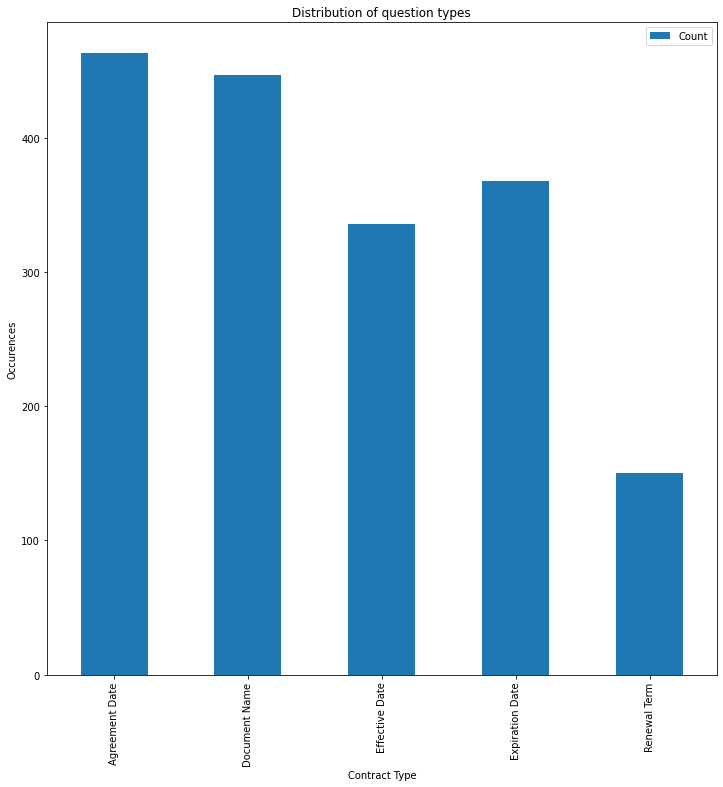

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,12))

_df = df.groupby('question').count()
_df['Contract Type']=[x.split('"')[1] for x in df.groupby('question').count().index.unique()]
_df.plot.bar(x='Contract Type',y='answer', title="Distribution of question types", legend=False, ax=ax, ylabel='Occurences')
ax.legend(['Count'])
plt.savefig('QuestionDistribution.png')

In [26]:
df.iloc[-1].context

'e receipt and sufficiency of which are hereby acknowledged, the parties agree as follows:\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n1. Definitions. As used herein, the following terms shall be defined as set forth below:\n\n  a. "Contract Period" shall mean that period of time from February 21, 2011 through December 31, 2012.\n\n  b. "Contract Year" shall mean the specific period of time during the Contract Period as more specifically set forth below:    · Contract Year 2011 (2/21/11 - 12/31/11)    · Contract Year 2012 (1/1/12- 12/31/12)\n\n  c. "Contract Territory" shall mean the world.\n\n  d. "North\'s Likeness" shall mean and include North\'s name, image, photograph, voice, initials, signature, biographical information, and  persona.\n\n  f. "North\'s Endorsement" shall mean and include North\'s public statements and commen'